In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
# All in RGB
all_valid_colors = [
    [0, 0, 0],
	[255, 255, 255],
	[231, 120, 23],
	[0, 147, 221],
	[245, 240, 20],
	[75, 176, 51],
	[218, 37, 29],
]

THRESH = 0.9

In [3]:
full_img = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg"
full_img = np.array(cv2.imread(full_img, cv2.IMREAD_COLOR))
full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

In [ ]:
def get_rgb_masks(full_img, reference_RGB, threshold=0.1):
    '''
    Efficiently computes binary masks for each reference RGB color.

    Args:
        full_img: RGB image, uint8 (0-255) or float32 normalized (0-1)
        reference_RGB: array-like list of RGB reference colors (same scale as full_img)
        threshold: relative threshold (0-1), distance fraction of max RGB distance (441)

    Returns:
        List of binary masks (uint8, 0-255) for each reference color
    '''
    h, w, _ = full_img.shape
    pixels = full_img.reshape(-1, 3).astype(np.float32)

    # If image is normalized, bring to 0-255 scale
    if pixels.max() <= 1.0:
        pixels *= 255.0

    C = np.array(reference_RGB, dtype=np.float32)  # (N,3)

    # Precompute norms
    pixels_norm2 = np.sum(pixels**2, axis=1, keepdims=True)  # (num_pixels,1)
    C_norm2 = np.sum(C**2, axis=1)  # (N,)

    # Compute squared distances
    dots = pixels @ C.T  # (num_pixels, N)
    dists2 = pixels_norm2 - 2*dots + C_norm2  # broadcasting (num_pixels,N)

    nearest_idx = np.argmin(dists2, axis=1)
    min_dists = np.min(dists2, axis=1)

    # Threshold squared
    abs_thresh = (threshold * 441.67295593)**2

    # Build binary masks
    results_rgb = []
    for i in range(len(reference_RGB)):
        mask_flat = (nearest_idx == i) & (min_dists < abs_thresh)
        mask_img = (mask_flat.reshape(h, w).astype(np.uint8)) * 255
        results_rgb.append(mask_img)

    return results_rgb


In [ ]:
masks = get_rgb_masks(full_img, all_valid_colors, threshold=0.1)

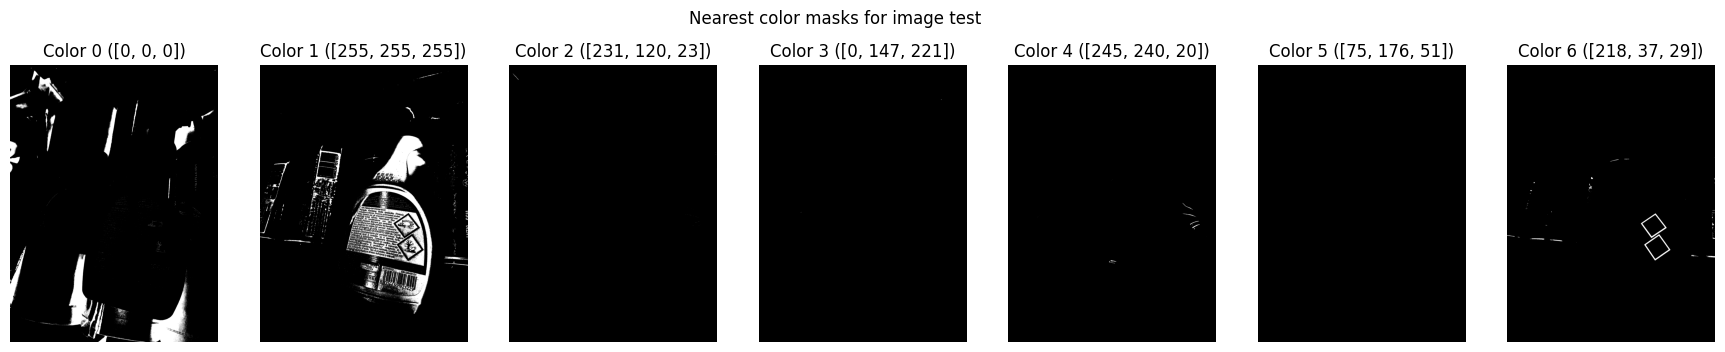

In [6]:

fig, axs = plt.subplots(1, len(masks), figsize=(22, 4))
fig.suptitle("Nearest color masks for image test")

for i in range(len(masks)):
	axs[i].imshow(masks[i], cmap='gray')
	axs[i].set_title(f"Color {i} ({all_valid_colors[i]})")
	axs[i].axis('off')

plt.show()

In [ ]:
def get_rgb_masks_with_black_white(full_img, reference_RGB, 
    threshold=0.1, 
    black_val_threshold=50, 
    white_sat_threshold=0.2, white_val_threshold=180):

    '''
    Combines RGB nearest color for chromatic masks + explicit cuts for black/white.

    Args:
        full_img: RGB image uint8 (H,W,3)
        reference_RGB: list of RGB colors
        threshold: fraction of max RGB distance (0-1)
        black_val_threshold: max intensity for black (0-255)
        white_sat_threshold: max (std dev / mean) across RGB for white
        white_val_threshold: min intensity for white (0-255)

    Returns:
        list of masks for each reference color + black mask + white mask
    '''
    h, w, _ = full_img.shape
    pixels = full_img.reshape(-1, 3).astype(np.float32)

    # 1. Black mask
    pixel_vals = np.mean(pixels, axis=1)  # (num_pixels,)
    black_mask_flat = (pixel_vals < black_val_threshold)

    # 2. White mask
    pixel_std = np.std(pixels, axis=1)
    white_mask_flat = (pixel_std / (pixel_vals + 1e-5) < white_sat_threshold) & \
                      (pixel_vals > white_val_threshold)

    # 3. Color distance masks (ignore black & white pixels)
    C = np.array(reference_RGB, dtype=np.float32)
    pixels_norm2 = np.sum(pixels**2, axis=1, keepdims=True)
    C_norm2 = np.sum(C**2, axis=1)
    dots = pixels @ C.T
    dists2 = pixels_norm2 - 2*dots + C_norm2

    # Invalidate black & white zones
    dists2[black_mask_flat | white_mask_flat, :] = np.inf

    nearest_idx = np.argmin(dists2, axis=1)
    min_dists2 = np.min(dists2, axis=1)
    abs_thresh2 = (threshold * 441.67295593)**2

    # 4. Build masks
    results_masks = []
    for i in range(len(reference_RGB)):
        mask_flat = (nearest_idx == i) & (min_dists2 < abs_thresh2)
        mask_img = (mask_flat.reshape(h,w).astype(np.uint8)) * 255
        results_masks.append(mask_img)

    # 5. Add black + white masks
    black_img = black_mask_flat.reshape(h,w).astype(np.uint8) * 255
    white_img = white_mask_flat.reshape(h,w).astype(np.uint8) * 255
    results_masks.append(black_img)
    results_masks.append(white_img)

    return results_masks

In [10]:
all_valid_minus_bw = [c for c in all_valid_colors if np.all(c) != 255 and np.all(c) != 0]

masks_2 = get_rgb_masks_with_black_white(full_img, all_valid_minus_bw, threshold=0.1)

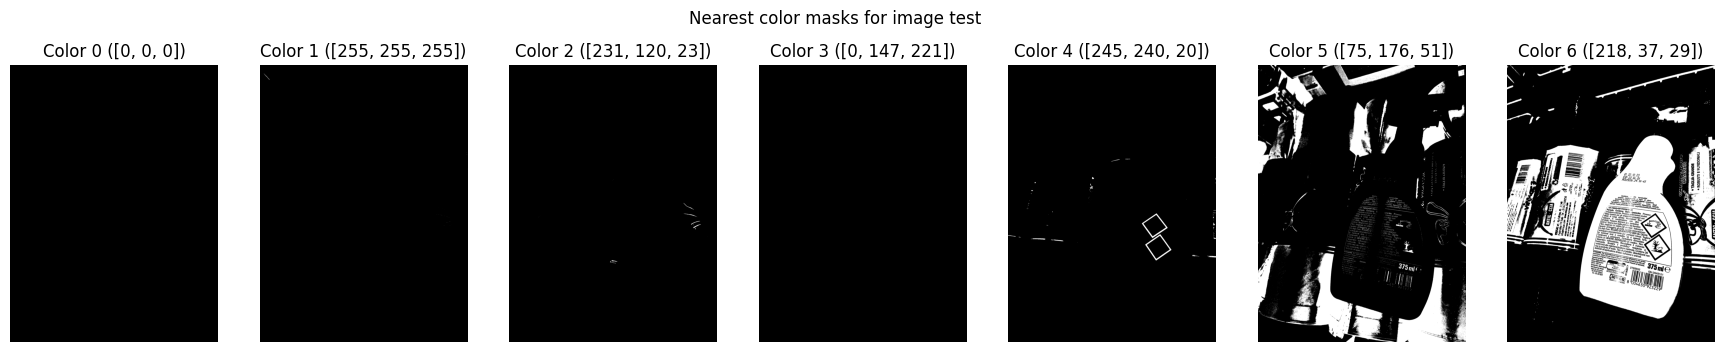

In [11]:

fig, axs = plt.subplots(1, len(masks_2), figsize=(22, 4))
fig.suptitle("Nearest color masks for image test")

for i in range(len(masks_2)):
	axs[i].imshow(masks_2[i], cmap='gray')
	axs[i].set_title(f"Color {i} ({all_valid_colors[i]})")
	axs[i].axis('off')

plt.show()